# Cooke triplet optimizaiton

I'm going to try and come up with a better "user interface" for optimization, based on the Cooke triplet example from this page:

https://wp.optics.arizona.edu/jsasian/wp-content/uploads/sites/33/2016/03/L20_OPTI517_Cooke_triplet.pdf

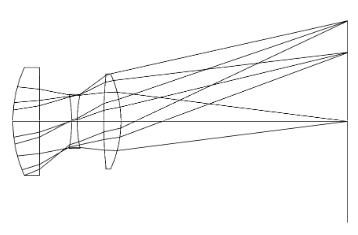

In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import opticsRayTrace.rayTraceTools as rtt
import opticsRayTrace.drawing as rtd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


I'm going to try identifying the variables, within the surface list, for readability. Then the optimization process can automate bundling the list of variables into a 1-d numeric array for the minimize() function.

In [11]:
surface_list = [{'surf': 'dummy', 'dist': -10},
 {'surf': 'dummy', 'dist': 10},
 {'surf': 'conic',
  'c': 0.042170961076202926,
  'k': 0,
  'dist': 4.831,
  'draw_radius': 10,
  'material': 'N-LAK9',
     'variables': ['c']},
 {'surf': 'conic',
  'c': 0.00013640168003221264,
  'k': 0,
  'dist': 5.86,
  'draw_radius': 10,
     'variables': ['c']},
 {'surf': 'conic',
  'c': -0.04088976120379457,
  'k': 0,
  'dist': 0.975,
  'draw_radius': 10,
  'material': 'N-SF5',
  'stop': True,
     'variables': ['c']},
 {'surf': 'conic',
  'c': 0.04567044208987943,
  'k': 0,
  'dist': 4.822,
  'draw_radius': 10,
     'variables': ['c']},
 {'surf': 'conic',
  'c': 0.011526181721781025,
  'k': 0,
  'dist': 3.127,
  'draw_radius': 10,
  'material': 'N-LAK9',
     'variables': ['c']},
 {'surf': 'conic',
  'c': -0.04879429301948844,
  'k': 0,
  'dist': 41.10346,
  'draw_radius': 10,
 'variables': ['c']},
 {'surf': 'dummy'}]

stop_surface = 4

Prior to optimization, I'll take care of some housekeeping, such as documenting the starting point, ray aiming, and finding convenient diameters for drawing.

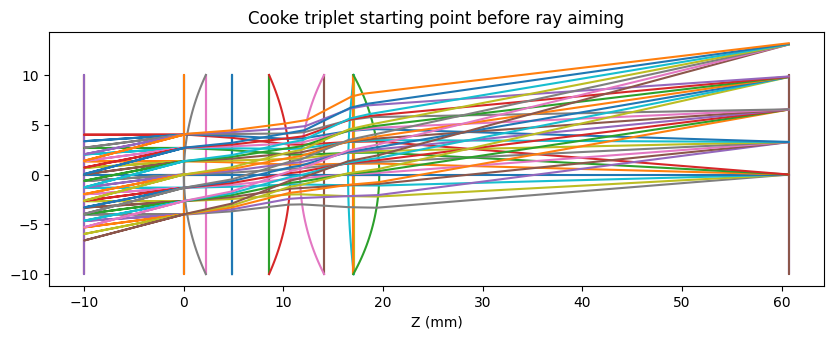

In [12]:
geometry = rtt.build_geometry(surface_list)

# Lists of field anles, pupil heights, and (for now) zero pupil shifts

lsf = np.linspace(0, 15, 5) #np.linspace(-10, 10, 3)
lsp = np.linspace(-4, 4, 7)
lsps = np.zeros_like(lsf)

# turn those lists into rays

field_rays = np.array([np.array([x*np.pi/180, 0, 1]) for x in lsf])
pupil_points = np.array([np.array([x, 0, 0]) for x in lsp])
pupil_shifts = np.array([np.array([x, 0, 0]) for x in lsps])
wavls = np.array([0.000633])

# my usual ray tracing steps

ray_table = rtt.new_ray_table(geometry, field_rays, pupil_points, wavls, infinite = True,
                             pupil_shifts = pupil_shifts)
rtt.propagate_ray(ray_table, geometry)

# now let's see what we've got

axd = rtd.new_plot_xy(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, marker = '.', markersize = 3)
axd["axs"][0].set_title("Cooke triplet starting point before ray aiming")
plt.show()

The apparent entrance pupil is at the entrance to the system, not where we want it. Now I need to choose values for the pupil shifts. I will say that the rays are correctly "aimed" when the ray bundle for each field angle is centered at the stop surface, i.e., that the squared position of those rays is at a minimum. This suggests a merit function and optimization.

In [13]:
def ray_aiming_merit(lsps):
    '''
    Merit function for ray aiming optimization, using lots of globals defined above
    
    lsps = list of pupil shifts
    '''
    
    # Convert pupil shifts into 3 dimensional points
    
    pupil_shifts = np.array([np.array([x, 0, 0]) for x in lsps])
    
    # Build a new ray table with those shifts, and trace the rays
    
    ray_table = rtt.new_ray_table(geometry, field_rays, pupil_points, wavls, infinite = True,
                             pupil_shifts = pupil_shifts)
    
    rtt.propagate_ray(ray_table, geometry)
    
    # Compute the merit function based on the squres of X positions
    
    merit = np.average(ray_table[stop_surface, :, 0, 0]**2)
    return merit

ray_aiming_merit(lsps)

5.7920915675540465

I've been having pretty good luck with the default minimization function from SciPy, so let's just try it, with starting values of zero.

In [14]:
m = minimize(ray_aiming_merit, lsps)
lsps_aimed = m['x']
lsps_aimed

array([ 0.        , -0.73768792, -1.48552961, -2.25516972, -3.06161424])

Now let's apply the new pupil shifts and trace the rays again

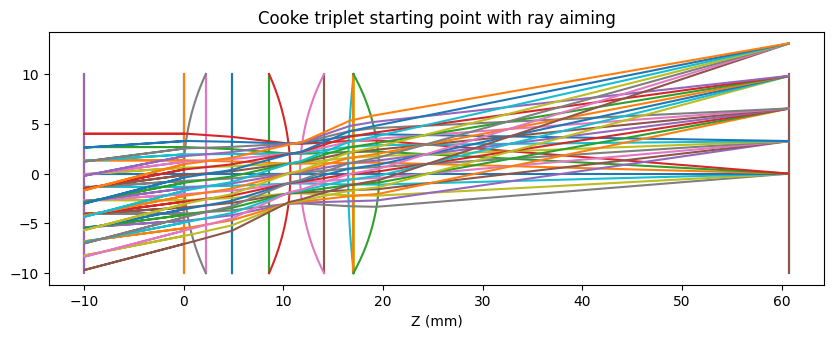

In [15]:
pupil_shifts = np.array([np.array([x, 0, 0]) for x in lsps_aimed])
ray_table = rtt.new_ray_table(geometry, field_rays, pupil_points, wavls, infinite = True,
                             pupil_shifts = pupil_shifts)
rtt.propagate_ray(ray_table, geometry)
axd = rtd.new_plot_xy(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, marker = '.', markersize = 3)
axd["axs"][0].set_title("Cooke triplet starting point with ray aiming")
plt.show()

One last trimming: I didn't give any radii for drawing the surfaces, and it's hard to visually compare the drawings to the one from the reference, so I created a little script that applies a default to each surface, just big enough to contain the rays, plus a margin. This is purely aesthetic. My program doesn't do anything with the draw radius while ray tracing.

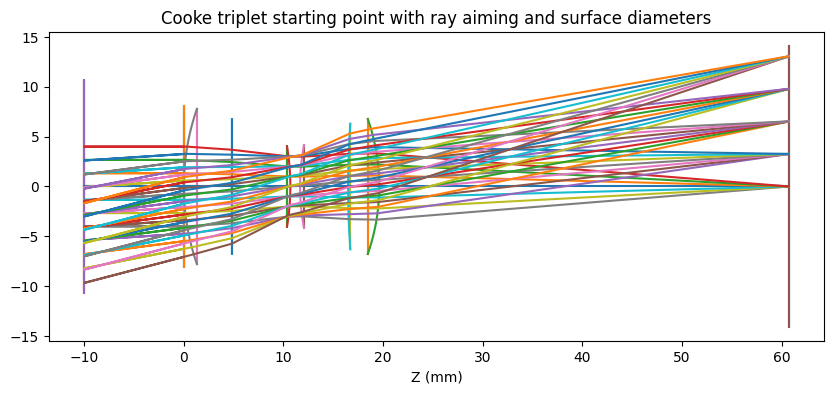

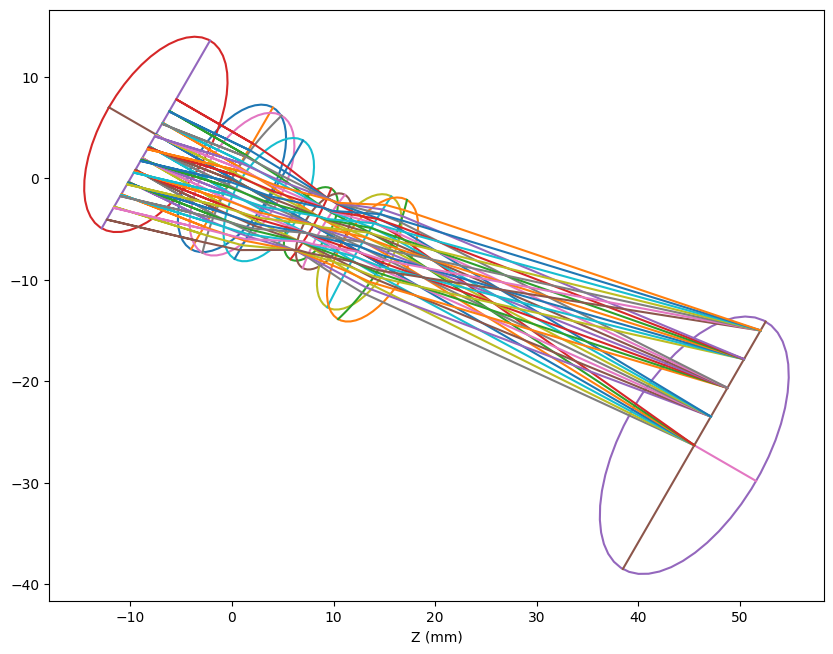

In [16]:
def find_draw_radii(ray_table):
    radius_list = []
    for surf in range(ray_table.shape[0]):
        radius = np.max(np.sqrt(np.sum(ray_table[surf, :, 0, :-1]**2, axis = 1)))
        radius_list.append(radius)
    return np.array(radius_list)

def apply_draw_radii(geometry, ray_table, margin):
    radii = find_draw_radii(ray_table) + margin
    for i in range(len(geometry)):
        geometry[i]['draw_radius'] = radii[i]
        
apply_draw_radii(geometry, ray_table, 1)
axd = rtd.new_plot_xy(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, marker = '.', markersize = 3)
axd["axs"][0].set_title("Cooke triplet starting point with ray aiming and surface diameters")
plt.show()
axd = rtd.new_plot_xy(axes = ["3d"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, marker = '.', markersize = 3)
plt.show()

I'm going to define a really basic merit, which will be the sum of RMS spot sizes. For this purpose, the rays have to be separated by field, so that each field gets its own RMS value.

In [17]:
def rms_by_field(ray_table):
    '''
    Compute RMS spot size as a function of field number for X ad Y
    '''
    
    rayx = ray_table[-1, :, 0, 0]
    rayy = ray_table[-1, :, 0, 1]
    rayfields = ray_table[-1, :, 3, 0].astype(int)
    return np.array([[np.std(rayx[rayfields == f]), np.std(rayy[rayfields == f])] 
                     for f in np.arange(np.max(rayfields) + 1)])

rms_by_field(ray_table)

array([[0.00426312, 0.        ],
       [0.0045466 , 0.        ],
       [0.00544095, 0.        ],
       [0.00674451, 0.        ],
       [0.0069538 , 0.        ]])

Now I'm going to experiment with automating the extraction of variables and generating a merit function.

In [18]:
def get_variables(surface_list):
    result = []
    for surface, n in zip(surface_list, range(len(surface_list))):
        if 'variables' in surface:
            for v in surface['variables']:
                result.append([n, v])
    return result

variables = get_variables(surface_list)
variables

[[2, 'c'], [3, 'c'], [4, 'c'], [5, 'c'], [6, 'c'], [7, 'c']]

In [19]:
def get_starting_points(surface_list, variables):
    result = []
    for v in variables:
        result.append(surface_list[v[0]][v[1]])
    return np.array(result)

starting_points = get_starting_points(surface_list, variables)
starting_points

array([ 0.04217096,  0.0001364 , -0.04088976,  0.04567044,  0.01152618,
       -0.04879429])

This cell builds the merit function by populating the variables and then tracing the rays. Since my variables don't include any distances or coordinate transformations, I don't strictly need the build_geometry() function, but it's also not very costly.

Notice that the parameters are all multiplicative factors, meaning that they all start out at 1. This is equivalent to "normalizing" coefficients in machine learning exercises. I decided to try it here because it seems to make fitting more stable. For instance, calling minimize() without specifying a method fails without normalization, and succeeds with normalization.

In [20]:
def merit(p):
    for v, i in zip(variables, range(len(variables))):
        surface_list[v[0]][v[1]] = p[i]*starting_points[i]
    geometry = rtt.build_geometry(surface_list)
    rtt.propagate_ray(ray_table, geometry)
    return np.sum(rms_by_field(ray_table)**2)

merit(np.ones_like(starting_points))

0.00016229343929292852

Finally, I'm just going to naievely throw the merit function into the minimize() process without any special settings, and see what happens. I've found that when the optimization fails, choosing **method = 'Nelder-Mead'** makes it more stable. That's what we used to call the Simplex algorithm. We don't need sophisticated optimization here, just something that works. For one thing, all of the best parameters will be subject to manufacturing tolerances in the real world.

In [21]:
minimize(merit, np.ones_like(starting_points))

      fun: 5.504373668218615e-06
 hess_inv: array([[ 3.07317849e+02,  2.06110169e+01, -3.85555508e+02,
         6.31290350e+01, -1.32941334e+03, -3.53257140e+02],
       [ 2.06110169e+01,  2.69287165e+00, -3.08081282e+01,
         2.39732886e-01, -1.07940035e+02, -2.61723275e+01],
       [-3.85555508e+02, -3.08081282e+01,  5.73535793e+02,
        -1.60784079e+01,  1.96942892e+03,  4.89980092e+02],
       [ 6.31290350e+01,  2.39732887e-01, -1.60784079e+01,
         6.65149098e+01, -3.17948756e+01, -3.92146955e+01],
       [-1.32941334e+03, -1.07940035e+02,  1.96942892e+03,
        -3.17948755e+01,  6.88813276e+03,  1.67942796e+03],
       [-3.53257140e+02, -2.61723275e+01,  4.89980092e+02,
        -3.92146955e+01,  1.67942796e+03,  4.32197155e+02]])
      jac: array([-1.29341191e-06, -6.65107791e-08,  1.48563373e-06,  9.00163855e-08,
       -2.17754632e-08, -2.30960137e-06])
  message: 'Optimization terminated successfully.'
     nfev: 455
      nit: 60
     njev: 65
   status: 0
  succ

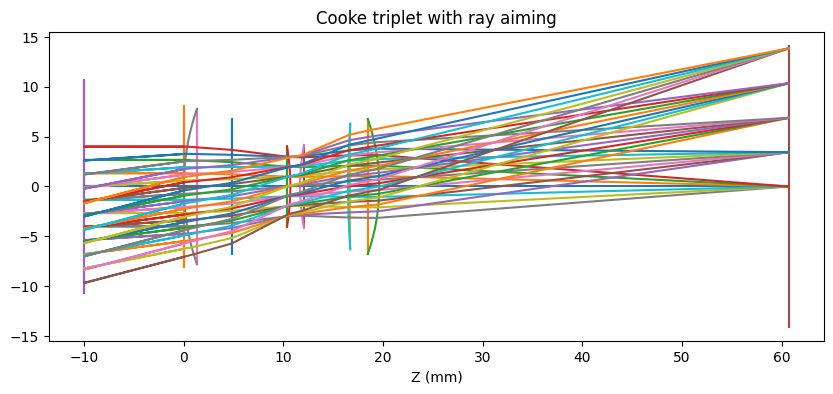

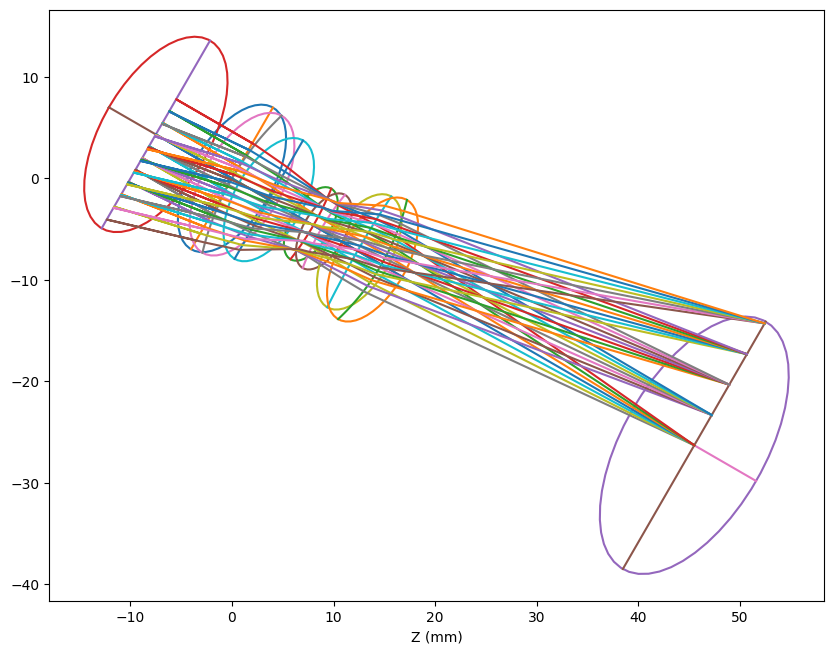

In [22]:
axd = rtd.new_plot_xy(axes = ["x"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, marker = '.', markersize = 3)
axd["axs"][0].set_title("Cooke triplet with ray aiming")
plt.show()
axd = rtd.new_plot_xy(axes = ["3d"], figsize = (10, 10))
rtd.plot_faces(axd, geometry)
rtd.plot_rays(axd, geometry, ray_table, marker = '.', markersize = 3)